<a href="https://colab.research.google.com/github/James1996GitHub/Kettle-Vs-Microwave/blob/main/CNN%20Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounts our Googled drive envirement to the session so we can import data in stroed in our Google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports all the libaries we will need to run this script.

In [ ]:
import os 
import pandas as pd
import csv
import numpy as np
import PIL.Image

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

import sklearn
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


In [ ]:
print('Is using GPU?', tf.test.is_gpu_available())

Saving the locations of our image data from google drive so they can be called more conviently later on. 

In [ ]:
trainPath = '/content/drive/MyDrive/Data/TrainingData'
testPath = '/content/drive/MyDrive/Data/TestingData/Data'
kettlesPath = '/content/drive/MyDrive/Data/TrainingData/Kettle'
microwavePath = '/content/drive/MyDrive/Data/TrainingData/Microwave'
numKettles = len(os.listdir(kettlesPath))
numMicrowaves = len(os.listdir(microwavePath))
numTestImages = len(os.listdir(testPath))
print('Number of kettles:', numKettles)
print('Number of microwaves:', numMicrowaves)
print('Number of test images:', numTestImages)

Number of kettles: 201
Number of microwaves: 109
Number of test images: 30


Saving the locations of our CSV data from Google drive so they can be called more conviently later on. 

In [ ]:
testCSVPath = '/content/drive/MyDrive/Data/TestingData/Test - Sheet1.csv'
testDataShape = pd.read_csv(testCSVPath,names= ['Image File'],skiprows=1)
testDataShape

,Image File
0,Kettle1.jpg
1,Kettle2.jpg
2,Kettle3.jpg
3,Kettle4.jpg
4,Kettle5.jpg
5,Kettle6.jpg
6,Kettle7.jpg
7,Kettle8.jpg
8,Kettle9.jpg
9,Kettle10.jpg


Setting our hyperparameters.

In [ ]:
epochs = 25 #Number of times will will cycle our data through the CNN during training.
batchSize = 16 #Number of images passed though at a time.
inputSize = (224,224) #Size images need to be resized to inorder to fit into the CNN input layer. 
classes = ['Kettle','Microwave'] #Defining the groups we want our CNN to sort its preditions into.

Here we are defining the preprocessing steps we need carried out on our raw image data so that it can be reformated into a format that can passed into our CNNs input player for training. This includes data augmentation techniques that are used to provide extra diversity in the dataset for training.

In [ ]:
trainImagePreprocessing=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
                                            shear_range=0.2,
                                            rotation_range=45,
                                            fill_mode='reflect',
                                            validation_split=0.3,
                                            horizontal_flip = True)

testImagePreprocessing=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

#training generator
trainGenerator=trainImagePreprocessing.flow_from_directory(directory= trainPath,
                                            target_size = inputSize,
                                            batch_size = batchSize,
                                            classes = classes,
                                            class_mode = "categorical",
                                            subset = "training",
                                            shuffle = True,
                                            seed = False)

#validation generator
validationGenerator=trainImagePreprocessing.flow_from_directory(directory= trainPath,
                                            target_size = inputSize,
                                            batch_size = batchSize,
                                            classes = classes,
                                            class_mode = "categorical",
                                            subset = "validation",
                                            shuffle = True,
                                            seed = False)
#test generator
testGenerator = testImagePreprocessing.flow_from_dataframe(dataframe=testDataShape,
                                            directory=testPath,
                                            x_col='Image File',
                                            y_col=None,
                                            target_size= inputSize,
                                            batch_size=30,
                                            class_mode=None,
                                            shuffle= False,
                                            validate_filenames=True)



Found 218 images belonging to 2 classes.
Found 92 images belonging to 2 classes.
Found 30 validated image filenames.


In [ ]:
testGenerator

Loading the CNN model. This model has its initial layers pretained on data set from the 'Imagenet' database. We are only using our data to train the later convolutional layers of the network. 

In [ ]:
base_model = tf.keras.applications.inception_v3.InceptionV3(weights="imagenet",
                                                            include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(2,activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
  layer.tranable = False


Defining the mertics we want to be caulated and displayed during training along with the optimizer chosen to minimise the loss value.

In [ ]:
model.compile(loss='categorical_crossentropy', 
              metrics=[tf.keras.metrics.Precision()],
              optimizer = 'sgd')

Kicks off the training process.

In [ ]:
STEP_SIZE_TRAIN=trainGenerator.n//trainGenerator.batch_size
STEP_SIZE_VALID=validationGenerator.n//validationGenerator.batch_size
birdBrain = model.fit_generator(generator=trainGenerator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=validationGenerator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=epochs)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
13/13 [==============================] - 113s 8s/step - loss: 0.6941 - precision_1: 0.5891 - val_loss: 0.6892 - val_precision_1: 0.5500
Epoch 2/25
13/13 [==============================] - 102s 8s/step - loss: 0.5068 - precision_1: 0.7376 - val_loss: 0.7725 - val_precision_1: 0.7125
Epoch 3/25
13/13 [==============================] - 102s 8s/step - loss: 0.4235 - precision_1: 0.8020 - val_loss: 0.7264 - val_precision_1: 0.6125
Epoch 4/25
13/13 [==============================] - 101s 8s/step - loss: 0.3391 - precision_1: 0.8960 - val_loss: 0.7259 - val_precision_1: 0.7625
Epoch 5/25
13/13 [==============================] - 101s 8s/step - loss: 0.3060 - precision_1: 0.8812 - val_loss: 0.3832 - val_precision_1: 0.7875
Epoch 6/25
13/13 [==============================] - 101s 8s/step - loss: 0.2231 - precision_1: 0.9208 - val_loss: 0.5748 - val_precision_1: 0.7000
Epoch 7/25
13/13 [==============================] - 101s 8s/step - loss: 0.1637 - precision_1: 0.9554 - val_loss: 0.50

Saving the weights of out trained model so that it can be recalled outside of the current session withought having to retrain the weights from scratch. 

In [ ]:
model.save('/content/drive/MyDrive/birdBrainModel/InceptionV3/birdBrainModel.h5')

Loads the weights of the cnn.

In [ ]:
birdBrain = tf.keras.models.load_model('/content/drive/MyDrive/birdBrainModel/InceptionV3/birdBrainModel.h5')

Here we are applying our trained model to the test data and it is returning a level of confidance for each class.

[kettle, microwave]

In [ ]:
ypred = birdBrain.predict(testGenerator,batchSize)
print(ypred)

[[9.7562510e-01 2.4374954e-02]
 [1.7422998e-01 8.2577002e-01]
 [5.5844712e-01 4.4155288e-01]
 [8.5438985e-01 1.4561018e-01]
 [9.9924952e-01 7.5050775e-04]
 [2.9160764e-02 9.7083920e-01]
 [1.4512222e-01 8.5487777e-01]
 [9.8549473e-01 1.4505215e-02]
 [9.9377948e-01 6.2204786e-03]
 [9.5442063e-01 4.5579433e-02]
 [9.9848539e-01 1.5146134e-03]
 [9.9544626e-01 4.5537357e-03]
 [9.9838579e-01 1.6142568e-03]
 [9.7906452e-01 2.0935535e-02]
 [7.5653440e-01 2.4346562e-01]
 [8.8072336e-01 1.1927665e-01]
 [9.4780976e-01 5.2190237e-02]
 [7.8882225e-02 9.2111784e-01]
 [8.2941301e-02 9.1705865e-01]
 [3.5712382e-04 9.9964285e-01]
 [1.0872863e-01 8.9127141e-01]
 [2.1026336e-01 7.8973663e-01]
 [1.7505317e-03 9.9824947e-01]
 [1.3541401e-02 9.8645860e-01]
 [3.1505519e-01 6.8494481e-01]
 [2.1822723e-03 9.9781775e-01]
 [2.9627133e-02 9.7037292e-01]
 [7.2477162e-02 9.2752278e-01]
 [1.0128146e-02 9.8987192e-01]
 [7.2455889e-04 9.9927551e-01]]


The two rows representing predidictions are checked and the row with the larger confidance is returned. Kettle = 0 as it was row 0 and microwave = 1 as it is row 1.

In [ ]:
predictions = np.argmax(ypred, axis = 1)
print(predictions)

[0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]


Defining what answser we know should be returned from our test data.

In [ ]:
testLables = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

Here we are defining the method that we can call upon to polt our Confusion Matrix.

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, ['Kettles Predicted','Microwaves Predicted'], rotation=45)
    plt.yticks(tick_marks, ['Kettles Labled','Microwaves Labled'])

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

This section of code polts and displays the Confusion Matrix by calling the function we defined in the code snippit above.


Confusion matrix, without normalization
[[12  3]
 [ 2 13]]


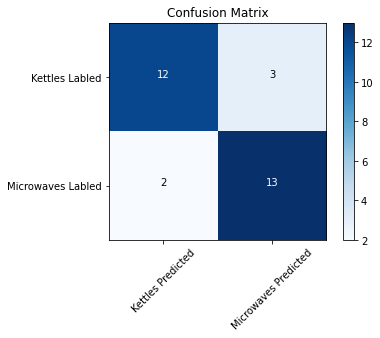

In [ ]:
cm = confusion_matrix(y_true=testLables, y_pred=predictions)
plot_confusion_matrix(cm=cm, classes=classes,title='Confusion Matrix')

This section applies the CNN to 1 single image and determins the class of that image.

In [ ]:
imPath = '/content/drive/MyDrive/Data/TestingData/Data/Kettle8.jpg'
# convert image to PIL image
image = tf.keras.preprocessing.image.load_img(imPath)
# convert image to numpy array
input_arr = tf.keras.preprocessing.image.img_to_array(image)
# convert single image to a batch
input_arr = np.array([input_arr])
# apply our preprocessing to the array to fit CNN input layer
input_arr = tf.keras.applications.inception_v3.preprocess_input(input_arr)
# applies the trained model to 
ypred = birdBrain.predict(input_arr)
# determins most likley class and prints the results by comparing the rows of the ouputted matrix
prediction = np.argmax(ypred, axis=1)
print(ypred)
print(prediction)
if prediction == 0:
  print('Kettle detected')
elif prediction == 1:
  print('Microwave detected')



[[0.5373729  0.46262705]]
[0]
Kettle detected
